In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import time
import datetime

from IPython import display
%load_ext tensorboard

In [2]:
# Configuration
DATA_PATH = './dataset_alt/'
OUTPUT_PATH = './output_alt/'
# OUTPUT_NPY = './output_alt/chopin/'
EPOCHS = 50
BATCH_SIZE = 5
BUFFER_SIZE = 60000

In [3]:
# images = glob.glob(DATA_PATH + '/*.npy')
# train_images = []
# for image in images:
#     img = np.load(image)
# #     print(img.shape)
#     train_images.append(img)
# train_images = np.array(train_images)
# # print(train_images)
# train_images = train_images.reshape(train_images.shape[0], 96, 1152, 1).astype('float32')
# train_images = (train_images) / 512 # Normalize the images to [-1, 1]
# print(train_images[5].shape)

In [4]:
def image_gen(composer):
    images = glob.glob(DATA_PATH + composer + '/*.npy')
    for image in images:
        y = np.load(image)
        y = y.reshape(*y.shape, -1)
        y = y / 512
        yield y

In [5]:
# train_images.shape

In [6]:
# train_dataset = tf.data.Dataset.from_generator(image_gen, output_types=tf.float32)
# train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE)


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*192*1, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 192, 1)))
    assert model.output_shape == (None, 16, 192, 1) # Note: None is the batch size
#     print(model.output_shape)

    model.add(layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 192, 128)
#     print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 384, 64)
#     print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(3, 3), padding='same', use_bias=False, activation='relu'))
    assert model.output_shape == (None, 96, 1152, 1)
#     print(model.output_shape)

    return model

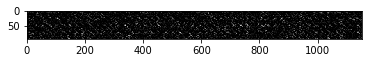

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 1152, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00033764]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      print("gen_loss={}, disc_loss={}".format(gen_loss, disc_loss))
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    with train_summary_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [18]:
def train(dataset, epochs, composer):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
        train_step(image_batch, epoch)
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, composer)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, composer)

In [19]:
def generate_and_save_images(model, epoch, test_input, composer):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(64, 64))
  for i in range(predictions.shape[0]):
        
#       display.display(PIL.Image.fromarray(predictions[i, :, :, 0].numpy().round()).convert('1'))
      np.save('{}/image_at_epoch_{:04d}_{}.png'.format(OUTPUT_PATH + composer,epoch,i), (predictions[i, :, :, 0].numpy() * 254))
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, 0]) * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('{}image_at_epoch_{:04d}.png'.format(OUTPUT_PATH,epoch), pad_inches=0, bbox_inches='tight', transparent=True)
  plt.show()

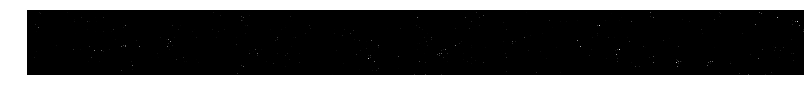

In [20]:
name = 'Henry_Purcell'
train_dataset = tf.data.Dataset.from_generator(lambda: image_gen(name), output_types=tf.float32)
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE)
train(train_dataset, 50, name)

In [21]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [22]:
anim_file = 'gan_alt_alban.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('{}image*.png'.format(OUTPUT_PATH))
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    if i > EPOCHS:
        break
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [23]:
plot_model(discriminator, show_shapes=True, to_file="disc_alt.png")

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [24]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              307200    
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3072)              0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 192, 1)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 192, 128)      512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 192, 128)      512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 192, 128)      0

In [25]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 576, 64)       1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 48, 576, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 576, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 288, 128)      204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 288, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 288, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 884736)           